[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/adaptive-intelligent-robotics/QDax/blob/main/examples/cmaes.ipynb)

# Optimizing with CMA-ES in Jax

This notebook shows how to use QDax to find performing parameters on Rastrigin and Sphere problems with [CMA-ES](https://arxiv.org/pdf/1604.00772.pdf). It can be run locally or on Google Colab. We recommand to use a GPU. This notebook will show:

- how to define the problem
- how to create a CMA-ES optimizer
- how to launch a certain number of optimizing steps
- how to visualise the optimization process

In [1]:
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

from qdax.core.cmaes import CMAES

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Set the hyperparameters

In [9]:
#@title Hyperparameters
#@markdown ---
num_iterations = 1000 #@param {type:"integer"}
num_dimensions = 100 #@param {type:"integer"}
batch_size = 36 #@param {type:"integer"}
num_best = 18 #@param {type:"integer"}
sigma_g = 0.5 # 0.5 #@param {type:"number"}
minval = -5.12 #@param {type:"number"}
optim_problem = "rastrigin" #@param["rastrigin", "sphere"]
#@markdown ---

## Define the fitness function - choose rastrigin or sphere

In [10]:
def rastrigin_scoring(x: jnp.ndarray):
    first_term = 10 * x.shape[-1]
    second_term = jnp.sum((x + minval * 0.4) ** 2 - 10 * jnp.cos(2 * jnp.pi * (x + minval * 0.4)))
    return -(first_term + second_term)

def sphere_scoring(x: jnp.ndarray):
    return -jnp.sum((x + minval * 0.4) * (x + minval * 0.4), axis=-1)

if optim_problem == "sphere":
    fitness_fn = sphere_scoring
elif optim_problem == "rastrigin":
    fitness_fn = jax.vmap(rastrigin_scoring)
else:
    raise Exception("Invalid opt function name given")

## Define a CMA-ES optimizer instance

In [11]:
cmaes = CMAES(
    population_size=batch_size,
    num_best=num_best,
    search_dim=num_dimensions,
    fitness_function=fitness_fn,
    mean_init=jnp.zeros((num_dimensions,)),
    init_sigma=sigma_g,
    delay_eigen_decomposition=True,
)

## Init the CMA-ES optimizer state

In [12]:
state = cmaes.init()
random_key = jax.random.PRNGKey(0)

## Run optimization iterations

In [13]:
%%time

means = [state.mean]
covs = [(state.sigma**2) * state.cov_matrix]

iteration_count = 0
for _ in range(num_iterations):
    iteration_count += 1
    
    # sample
    samples, random_key = cmaes.sample(state, random_key)
    
    # udpate
    state = cmaes.update(state, samples)
    
    # check stop condition
    stop_condition = cmaes.stop_condition(state)

    if stop_condition:
        break
    
    # store data for plotting
    means.append(state.mean)
    covs.append((state.sigma**2) * state.cov_matrix)
        
print("Num iterations before stop condition: ", iteration_count)

Num iterations before stop condition:  1000
CPU times: user 5.77 s, sys: 4.85 s, total: 10.6 s
Wall time: 4.96 s


## Check final fitnesses and distribution mean

In [14]:
# checking final fitness values
fitnesses = fitness_fn(samples)

print("Min fitness in the final population: ", jnp.min(fitnesses))
print("Mean fitness in the final population: ", jnp.mean(fitnesses))
print("Max fitness in the final population: ", jnp.max(fitnesses))

# checking mean of the final distribution
print("Final mean of the distribution: \n", means[-1])
# print("Final covariance matrix of the distribution: ", covs[-1])

Min fitness in the final population:  -124.369934
Mean fitness in the final population:  -124.36989
Max fitness in the final population:  -124.36987
Final mean of the distribution: 
 [ 0.05813844  2.048097    0.05815361  2.0482256   1.0530038   2.0480123
 -0.9370088   0.05811672  1.0528961   1.0529748   2.0480843   1.0531135
  2.048135    2.0482287   3.043082    0.058006    2.0480635   3.0429215
  2.048057    3.0429132   1.0532147   1.0529623   2.0481143   1.0530492
  3.0430367   1.0532606   2.0479438   4.0380373   3.043043    0.05828068
  3.0430183   1.0529833   1.0529994   1.0530311   1.0531095   2.0482633
  1.0529532   2.0481486   1.0530735   1.053044    2.0479047   3.0430338
  2.0481155   2.0481505   2.0480716   1.0530329   1.0529205   2.0479467
  1.0531003   1.053173    2.048085    1.0531372   0.05821279  1.0531647
  1.0530658   1.0531813   1.0530711   2.0479372   2.0478022   1.0531459
  2.0479965   1.053009    0.05807497  1.0530885   1.0528774   2.0481157
  0.05803945  0.05805986

## Visualization of the optimization trajectory

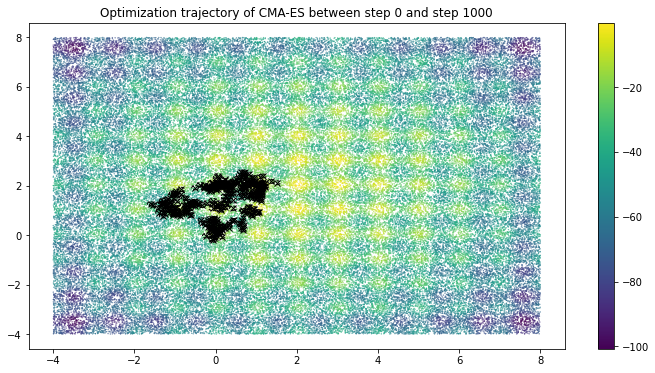

In [15]:
fig, ax = plt.subplots(figsize=(12, 6))

# sample points to show fitness landscape
random_key, subkey = jax.random.split(random_key)
x = jax.random.uniform(subkey, minval=-4, maxval=8, shape=(100000, 2))
f_x = fitness_fn(x)

# plot fitness landscape
points = ax.scatter(x[:, 0], x[:, 1], c=f_x, s=0.1)
fig.colorbar(points)

# plot cma-es trajectory
traj_min = 0
traj_max = iteration_count
for mean, cov in zip(means[traj_min:traj_max], covs[traj_min:traj_max]):
    ellipse = Ellipse((mean[0], mean[1]), cov[0, 0], cov[1, 1], fill=False, color='k', ls='--')
    ax.add_patch(ellipse)
    ax.plot(mean[0], mean[1], color='k', marker='x')
    
ax.set_title(f"Optimization trajectory of CMA-ES between step {traj_min} and step {traj_max}")
plt.show()